In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from pathlib import Path
import os
import pickle
from tqdm import tqdm
from config import model_config

from sklearn.ensemble import (
	RandomForestClassifier
)
from sklearn.feature_selection import(
	RFECV, SequentialFeatureSelector
)
from sklearn.linear_model import (
	LinearRegression, LogisticRegression,
)
from sklearn.metrics import (
	confusion_matrix, classification_report, f1_score,
	roc_curve, roc_auc_score
)
from sklearn.model_selection import (
	train_test_split, RandomizedSearchCV, GridSearchCV, 
	cross_val_score, cross_val_predict, KFold,
)
from sklearn.pipeline import (
	Pipeline
)
from sklearn.preprocessing import (
	LabelEncoder, OneHotEncoder, StandardScaler,
	RobustScaler, QuantileTransformer,
)
import statsmodels.api as sm

from regression import reg

In [2]:
SEED = 123
TEST_SIZE = 0.25

HEATMAP_COLORS = sns.diverging_palette(h_neg=359, h_pos=250, as_cmap=True)

# Import Data

In [8]:
with open(Path('../data/classification_data.pkl'), 'rb') as f:
	data = pickle.load(f)
	
X = data.get('X')
y = data.get('y')
body_features = data.get('body_features')
cardio_features = data.get('cardio_features')

print(X.shape)
print(y.shape)
print(body_features)
print(cardio_features)

X.head()

(42, 21)
(42, 1)
['density_visceral_fat', 'mass_visceral_fat', 'volume_intermuscular_fat', 'density_intermuscular_fat', 'density_bone', 'mass_bone', 'bmi']
['emphysema_volume_950hu', 'lung_volume', 'extrapulmonary_artery_volume', 'extrapulmonary_vein_volume', 'artery_vein_ratio', 'bv5', 'pb_larger_10', 'a_diameter', 'pv_a', 'heart_volume', 'airway_ratio', 'ild_volume']


,density_visceral_fat,mass_visceral_fat,volume_intermuscular_fat,density_intermuscular_fat,density_bone,mass_bone,bmi,emphysema_volume_950hu,lung_volume,extrapulmonary_artery_volume,...,artery_vein_ratio,bv5,pb_larger_10,a_diameter,pv_a,heart_volume,airway_ratio,ild_volume,age,gender_cl_Male
PE1_0,-0.804596,-1.006961,1.331630,-0.066012,-1.754047,1.134155,0.207862,0.480081,1.724862,5.199338,...,-0.996942,0.124882,1.843089,0.947761,1.199407,1.818949,-0.337578,-0.519639,-0.099108,1.0
PE12_0,-0.132313,0.893337,1.197132,-1.003148,-0.597841,1.032652,0.066012,0.138304,0.980188,0.817043,...,0.100068,0.794604,0.518666,-0.640149,1.252273,0.097809,0.469267,0.926287,-0.382953,1.0
PE14_0,1.412188,-0.675649,-1.039624,1.354934,-0.169270,0.766997,-0.514471,1.051576,1.240579,-0.292203,...,-0.101339,0.178621,0.072902,-0.200470,0.102281,0.113720,-0.634274,-5.199338,-1.008759,0.0
PE15_0,1.252120,-5.199338,-1.617132,1.252120,1.003148,-0.624630,-5.199338,0.156703,-1.004953,-0.828968,...,0.330129,0.595698,-0.975373,-1.654127,0.334016,-1.195727,0.077566,-0.078812,-5.199338,0.0
PE16_0,-2.005180,1.562232,1.726809,-1.681878,1.434005,0.950963,1.235224,-5.199338,-1.607868,-1.247606,...,-2.005675,-0.823376,0.054429,-1.244247,0.048821,-0.791093,1.626350,1.253523,-0.851690,0.0


In [9]:
y.head()

,resolved_pe
PE1_0,1.0
PE12_0,0.0
PE14_0,0.0
PE15_0,0.0
PE16_0,0.0


# Logit Regression

In [10]:
y.value_counts(dropna=False)

resolved_pe
0.0            27
1.0            15
dtype: int64

In [38]:
def combine_feat_and_controls(feat, controls=None):
	all_feat = list()
	all_feat.append(feat)
	if controls is not None:
		for control in controls:
			all_feat.append(control)
	return all_feat

def logit_regression(X, y, feat=None, controls=None):
	all_feat = combine_feat_and_controls(feat, controls)

	X_temp = sm.add_constant(X.loc[:, all_feat])
	logit_temp = sm.Logit(y, X_temp).fit(cov_type='HC3', disp=False)

	logit_probs = logit_temp.predict()
	fpr, tpr, thresholds = roc_curve(y, logit_probs)
	auc = roc_auc_score(y, logit_probs)
	
	return (
		logit_temp.params, 
		logit_temp.pvalues,
		fpr,
		tpr,
		thresholds,
		auc
	)

def logit_CV(X, y, n_splits, feat=None, controls=None):
	
	all_feat = combine_feat_and_controls(feat, controls)

	kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
	
	X = X[all_feat]
	
	true_labels = list()
	predicted_probs = list()
	coefficients = np.zeros((n_splits, X.shape[-1]))
	p_values = np.zeros((n_splits, X.shape[-1]))

	for i, (train_index, test_index) in enumerate(kf.split(X)):
		X_train, X_test = X.iloc[train_index], X.iloc[test_index]
		y_train, y_test = y.iloc[train_index], y.iloc[test_index]

		model = sm.Logit(y_train, X_train).fit(cov_type='HC3', disp=False)
		y_probs = model.predict(X_test)

		true_labels.extend(np.squeeze(np.array(y_test)))
		predicted_probs.extend(y_probs)
		coefficients[i] = model.params
		p_values[i] = model.pvalues
	
	# Convert labels and predicted probs to np.array
	true_labels = np.array(true_labels)
	predicted_probs = np.array(predicted_probs)

	# Compute the ROC curve
	fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)

	# Compute the AUC
	auc = roc_auc_score(true_labels, predicted_probs)
	
	# Compute mean coefficients and p-values
	overall_coef = np.mean(coefficients, axis=0)
	overall_p_values = np.mean(p_values, axis=0)
		
	return (
		overall_coef,
		overall_p_values,
		fpr,
		tpr,
		thresholds,
		auc
	)

def plot_roc(fpr, tpr, auc, custom_title=None):
	fig, ax = plt.subplots()
	ax.plot([0, 1], ls='--', c='r')
	ax.plot([0, 0], [1, 0], c='0.8')
	ax.plot([1, 0], [1, 1], c='0.8')
	ax.plot(fpr, tpr, label=f'ROC Curve (AUC={auc:.3})')
	if custom_title is not None:
		ax.set_title(f'Y=Resolved PE, {custom_title}', fontsize=16)
	else:
		ax.set_title(f'Y=Resolved PE', fontsize=16)
	ax.set_xlabel('False Positive Rate')
	ax.set_ylabel('True Positive Rate')
	plt.legend(fontsize=14)
	plt.show()

## Logit_CV

In [99]:
all_logit_cv_dfs = list()

In [100]:
logit_coefs = dict()
logit_pvals = dict()
logit_auc = dict()

for feature in BODY_FEAT_UNCORR:
	(
		coef, pvalues,
		fpr, tpr, thresholds, auc
	) = logit_CV(X_pp, y, feature, controls=None, n_splits=10)
	
	logit_coefs[feature] = coef[0]
	logit_pvals[feature] = pvalues[0]
	logit_auc[feature] = auc

	# plot_roc(fpr, tpr, auc, custom_title=f'X={feature}')

logit_results_df = pd.DataFrame(
	{
		'coef': logit_coefs,
		'pvalue': logit_pvals,
		'auc': logit_auc,
		'controls': 'None'
	}
)
# logit_results_df.to_csv('../output/regressions/logit_CV, body, controls=None.csv')
all_logit_cv_dfs.append(logit_results_df)
logit_results_df

,coef,pvalue,auc,controls
density_visceral_fat,-0.160123,0.542652,0.564198,None
mass_visceral_fat,0.153977,0.550928,0.432099,None
density_subcutaneous_fat,0.085609,0.711034,0.511111,None
mass_subcutaneous_fat,-0.207740,0.462116,0.604938,None
density_intermuscular_fat,0.193566,0.444819,0.479012,None
mass_intermuscular_fat,0.190091,0.443875,0.454321,None
density_muscle,-0.024111,0.777854,0.388889,None
mass_muscle,0.052093,0.708299,0.283951,None
volume_bone,0.159384,0.542606,0.513580,None
density_bone,-0.563110,0.102948,0.644444,None


In [101]:
logit_coefs = dict()
logit_pvals = dict()
logit_auc = dict()

for feature in BODY_FEAT_UNCORR:
	(
		coef, pvalues,
		fpr, tpr, thresholds, auc
	) = logit_CV(X_pp, y, feature, controls=['gender_cl_Male', 'age'], n_splits=10)
	
	logit_coefs[feature] = coef[0]
	logit_pvals[feature] = pvalues[0]
	logit_auc[feature] = auc

	# plot_roc(fpr, tpr, auc, custom_title=f'X={feature}')

logit_results_df = pd.DataFrame(
	{
		'coef': logit_coefs,
		'pvalue': logit_pvals,
		'auc': logit_auc,
		'controls': 'gender_cl_Male, age'
	}
)
# logit_results_df.to_csv('../output/regressions/logit_CV, body, controls=[gender_cl_Male, age].csv')
all_logit_cv_dfs.append(logit_results_df)
logit_results_df

,coef,pvalue,auc,controls
density_visceral_fat,-0.042563,0.756617,0.597531,"gender_cl_Male, age"
mass_visceral_fat,-0.097478,0.660251,0.595062,"gender_cl_Male, age"
density_subcutaneous_fat,0.246122,0.441170,0.622222,"gender_cl_Male, age"
mass_subcutaneous_fat,-0.436928,0.215314,0.609877,"gender_cl_Male, age"
density_intermuscular_fat,0.201536,0.510771,0.595062,"gender_cl_Male, age"
mass_intermuscular_fat,0.119022,0.624033,0.585185,"gender_cl_Male, age"
density_muscle,0.109130,0.691808,0.570370,"gender_cl_Male, age"
mass_muscle,0.102607,0.592138,0.582716,"gender_cl_Male, age"
volume_bone,0.073256,0.700050,0.582716,"gender_cl_Male, age"
density_bone,-0.380096,0.294919,0.602469,"gender_cl_Male, age"


In [102]:
logit_coefs = dict()
logit_pvals = dict()
logit_auc = dict()

for feature in BODY_FEAT_UNCORR:
	(
		coef, pvalues,
		fpr, tpr, thresholds, auc
	) = logit_CV(X_pp, y, feature, controls=['gender_cl_Male'], n_splits=10)
	
	logit_coefs[feature] = coef[0]
	logit_pvals[feature] = pvalues[0]
	logit_auc[feature] = auc

	# plot_roc(fpr, tpr, auc, custom_title=f'X={feature}')

logit_results_df = pd.DataFrame(
	{
		'coef': logit_coefs,
		'pvalue': logit_pvals,
		'auc': logit_auc,
		'controls': 'gender_cl_Male'
	}
)
# logit_results_df.to_csv('../output/regressions/logit_CV, body, controls=[gender_cl_Male].csv')
all_logit_cv_dfs.append(logit_results_df)
logit_results_df

,coef,pvalue,auc,controls
density_visceral_fat,-0.133721,0.624417,0.593827,gender_cl_Male
mass_visceral_fat,0.132590,0.599763,0.516049,gender_cl_Male
density_subcutaneous_fat,0.080490,0.723144,0.592593,gender_cl_Male
mass_subcutaneous_fat,-0.191997,0.504746,0.604938,gender_cl_Male
density_intermuscular_fat,0.201559,0.433080,0.582716,gender_cl_Male
mass_intermuscular_fat,0.182366,0.470100,0.513580,gender_cl_Male
density_muscle,-0.050137,0.739058,0.559259,gender_cl_Male
mass_muscle,-0.007332,0.786816,0.491358,gender_cl_Male
volume_bone,0.112581,0.625164,0.545679,gender_cl_Male
density_bone,-0.546467,0.114267,0.614815,gender_cl_Male


In [103]:
logit_coefs = dict()
logit_pvals = dict()
logit_auc = dict()

for feature in BODY_FEAT_UNCORR:
	(
		coef, pvalues,
		fpr, tpr, thresholds, auc
	) = logit_CV(X_pp, y, feature, controls=['age'], n_splits=10)
	
	logit_coefs[feature] = coef[0]
	logit_pvals[feature] = pvalues[0]
	logit_auc[feature] = auc

	# plot_roc(fpr, tpr, auc, custom_title=f'X={feature}')

logit_results_df = pd.DataFrame(
	{
		'coef': logit_coefs,
		'pvalue': logit_pvals,
		'auc': logit_auc,
		'controls': 'age'
	}
)
# logit_results_df.to_csv('../output/regressions/logit_CV, body, controls=[age].csv')
all_logit_cv_dfs.append(logit_results_df)
logit_results_df

,coef,pvalue,auc,controls
density_visceral_fat,-0.057768,0.733241,0.634568,age
mass_visceral_fat,-0.081486,0.688955,0.614815,age
density_subcutaneous_fat,0.248129,0.437004,0.664198,age
mass_subcutaneous_fat,-0.434879,0.203711,0.649383,age
density_intermuscular_fat,0.178113,0.553361,0.627160,age
mass_intermuscular_fat,0.121675,0.612329,0.624691,age
density_muscle,0.121705,0.676977,0.617284,age
mass_muscle,0.116199,0.544602,0.624691,age
volume_bone,0.095317,0.657655,0.614815,age
density_bone,-0.383737,0.289426,0.646914,age


In [104]:
all_logit_cv = pd.concat(all_logit_cv_dfs, axis=0)
all_logit_cv.head()

,coef,pvalue,auc,controls
density_visceral_fat,-0.160123,0.542652,0.564198,None
mass_visceral_fat,0.153977,0.550928,0.432099,None
density_subcutaneous_fat,0.085609,0.711034,0.511111,None
mass_subcutaneous_fat,-0.207740,0.462116,0.604938,None
density_intermuscular_fat,0.193566,0.444819,0.479012,None


In [105]:
all_logit_cv['indep_var'] = all_logit_cv.index
all_logit_cv.index = all_logit_cv.index + '(' + all_logit_cv['controls'] + ')'
all_logit_cv.head()

,coef,pvalue,auc,controls,indep_var
density_visceral_fat(None),-0.160123,0.542652,0.564198,None,density_visceral_fat
mass_visceral_fat(None),0.153977,0.550928,0.432099,None,mass_visceral_fat
density_subcutaneous_fat(None),0.085609,0.711034,0.511111,None,density_subcutaneous_fat
mass_subcutaneous_fat(None),-0.207740,0.462116,0.604938,None,mass_subcutaneous_fat
density_intermuscular_fat(None),0.193566,0.444819,0.479012,None,density_intermuscular_fat


In [106]:
all_logit_cv.to_csv('../output/regressions/logit_CV.csv')

## Logit (no CV)

In [107]:
all_logit_nocv_dfs = list()

In [108]:
logit_coefs = dict()
logit_pvals = dict()
logit_auc = dict()

for feature in BODY_FEAT_UNCORR:
	(
		coef, pvalues,
		fpr, tpr, thresholds, auc
	) = logit_regression(X_pp, y, feature, controls=None)
	
	logit_coefs[feature] = coef[0]
	logit_pvals[feature] = pvalues[0]
	logit_auc[feature] = auc

	# plot_roc(fpr, tpr, auc, custom_title=f'X={feature}')

logit_results_df = pd.DataFrame(
	{
		'coef': logit_coefs,
		'pvalue': logit_pvals,
		'auc': logit_auc,
		'controls': 'None',
	}
)

# logit_results_df.to_csv('../output/regressions/logit_noCV, body, controls=None.csv')
all_logit_nocv_dfs.append(logit_results_df)
logit_results_df

,coef,pvalue,auc,controls
density_visceral_fat,-0.597236,0.066022,0.596296,None
mass_visceral_fat,-0.593922,0.067031,0.585185,None
density_subcutaneous_fat,-0.589326,0.067834,0.550617,None
mass_subcutaneous_fat,-0.600933,0.065446,0.624691,None
density_intermuscular_fat,-0.598875,0.066198,0.504938,None
mass_intermuscular_fat,-0.594561,0.067841,0.498765,None
density_muscle,-0.587620,0.068076,0.520988,None
mass_muscle,-0.588455,0.067899,0.535802,None
volume_bone,-0.593883,0.067177,0.607407,None
density_bone,-0.653812,0.057619,0.661728,None


In [109]:
logit_coefs = dict()
logit_pvals = dict()
logit_auc = dict()

for feature in BODY_FEAT_UNCORR:
	(
		coef, pvalues,
		fpr, tpr, thresholds, auc
	) = logit_regression(X_pp, y, feature, controls=['gender_cl_Male', 'age'])
	
	logit_coefs[feature] = coef[0]
	logit_pvals[feature] = pvalues[0]
	logit_auc[feature] = auc

	# plot_roc(fpr, tpr, auc, custom_title=f'X={feature}')

logit_results_df = pd.DataFrame(
	{
		'coef': logit_coefs,
		'pvalue': logit_pvals,
		'auc': logit_auc,
		'controls': 'gender_cl_Male, age',
	}
)

# logit_results_df.to_csv('../output/regressions/logit_noCV, body, controls=[gender_cl_Male, age].csv')
all_logit_nocv_dfs.append(logit_results_df)
logit_results_df

,coef,pvalue,auc,controls
density_visceral_fat,-1.603339,0.006992,0.795062,"gender_cl_Male, age"
mass_visceral_fat,-1.605048,0.006747,0.785185,"gender_cl_Male, age"
density_subcutaneous_fat,-1.550170,0.008356,0.795062,"gender_cl_Male, age"
mass_subcutaneous_fat,-1.496563,0.010612,0.790123,"gender_cl_Male, age"
density_intermuscular_fat,-1.592593,0.006898,0.802469,"gender_cl_Male, age"
mass_intermuscular_fat,-1.579175,0.007298,0.787654,"gender_cl_Male, age"
density_muscle,-1.604841,0.007673,0.785185,"gender_cl_Male, age"
mass_muscle,-1.731681,0.005766,0.802469,"gender_cl_Male, age"
volume_bone,-1.755440,0.005500,0.809877,"gender_cl_Male, age"
density_bone,-1.626331,0.007650,0.817284,"gender_cl_Male, age"


In [110]:
logit_coefs = dict()
logit_pvals = dict()
logit_auc = dict()

for feature in BODY_FEAT_UNCORR:
	(
		coef, pvalues,
		fpr, tpr, thresholds, auc
	) = logit_regression(X_pp, y, feature, controls=['age'])
	
	logit_coefs[feature] = coef[0]
	logit_pvals[feature] = pvalues[0]
	logit_auc[feature] = auc

	# plot_roc(fpr, tpr, auc, custom_title=f'X={feature}')

logit_results_df = pd.DataFrame(
	{
		'coef': logit_coefs,
		'pvalue': logit_pvals,
		'auc': logit_auc,
		'controls': 'age'
	}
)

# logit_results_df.to_csv('../output/regressions/logit_noCV, body, controls=[age].csv')
all_logit_nocv_dfs.append(logit_results_df)
logit_results_df

,coef,pvalue,auc,controls
density_visceral_fat,-0.681239,0.053215,0.708642,age
mass_visceral_fat,-0.669169,0.057401,0.706173,age
density_subcutaneous_fat,-0.660969,0.060416,0.718519,age
mass_subcutaneous_fat,-0.691319,0.055849,0.730864,age
density_intermuscular_fat,-0.657226,0.061897,0.698765,age
mass_intermuscular_fat,-0.688401,0.052177,0.696296,age
density_muscle,-0.681744,0.053308,0.693827,age
mass_muscle,-0.686256,0.052579,0.698765,age
volume_bone,-0.685027,0.052851,0.696296,age
density_bone,-0.704785,0.050651,0.716049,age


In [111]:
logit_coefs = dict()
logit_pvals = dict()
logit_auc = dict()

for feature in BODY_FEAT_UNCORR:
	(
		coef, pvalues,
		fpr, tpr, thresholds, auc
	) = logit_regression(X_pp, y, feature, controls=['gender_cl_Male'])
	
	logit_coefs[feature] = coef[0]
	logit_pvals[feature] = pvalues[0]
	logit_auc[feature] = auc

	# plot_roc(fpr, tpr, auc, custom_title=f'X={feature}')

logit_results_df = pd.DataFrame(
	{
		'coef': logit_coefs,
		'pvalue': logit_pvals,
		'auc': logit_auc,
		'controls': 'gender_cl_Male',
	}
)

# logit_results_df.to_csv('../output/regressions/logit_noCV, body, controls=[age].csv')
all_logit_nocv_dfs.append(logit_results_df)
logit_results_df

,coef,pvalue,auc,controls
density_visceral_fat,-1.555733,0.005145,0.744444,gender_cl_Male
mass_visceral_fat,-1.551483,0.005106,0.723457,gender_cl_Male
density_subcutaneous_fat,-1.557662,0.004708,0.744444,gender_cl_Male
mass_subcutaneous_fat,-1.551631,0.005094,0.753086,gender_cl_Male
density_intermuscular_fat,-1.585258,0.004281,0.718519,gender_cl_Male
mass_intermuscular_fat,-1.540058,0.005236,0.708642,gender_cl_Male
density_muscle,-1.654664,0.004533,0.780247,gender_cl_Male
mass_muscle,-1.870370,0.002822,0.795062,gender_cl_Male
volume_bone,-1.725143,0.004031,0.762963,gender_cl_Male
density_bone,-1.647710,0.006049,0.785185,gender_cl_Male


In [112]:
all_logit_nocv = pd.concat(all_logit_nocv_dfs, axis=0)
all_logit_nocv.head()

,coef,pvalue,auc,controls
density_visceral_fat,-0.597236,0.066022,0.596296,None
mass_visceral_fat,-0.593922,0.067031,0.585185,None
density_subcutaneous_fat,-0.589326,0.067834,0.550617,None
mass_subcutaneous_fat,-0.600933,0.065446,0.624691,None
density_intermuscular_fat,-0.598875,0.066198,0.504938,None


In [113]:
all_logit_nocv['indep_var'] = all_logit_nocv.index
all_logit_nocv.index = all_logit_nocv.index + '(' + all_logit_nocv['controls'] + ')'
all_logit_nocv.head()

,coef,pvalue,auc,controls,indep_var
density_visceral_fat(None),-0.597236,0.066022,0.596296,None,density_visceral_fat
mass_visceral_fat(None),-0.593922,0.067031,0.585185,None,mass_visceral_fat
density_subcutaneous_fat(None),-0.589326,0.067834,0.550617,None,density_subcutaneous_fat
mass_subcutaneous_fat(None),-0.600933,0.065446,0.624691,None,mass_subcutaneous_fat
density_intermuscular_fat(None),-0.598875,0.066198,0.504938,None,density_intermuscular_fat


In [114]:
all_logit_nocv.to_csv('../output/regressions/logit_noCV.csv')

### Multivariable Analysis

#### Recursive Feature Selection

In [56]:
rfecv_results = dict()
target = 'resolved_pe'
model = LogisticRegression()

rfecv = RFECV(
	estimator=model,
	step=1,
	scoring='roc_auc',
	cv=10
)

rfecv.fit(X[cardio_features], np.array(y).ravel())
rfecv_results[target] = list(rfecv.get_feature_names_out())

rfecv_results

{'resolved_pe': ['lung_volume',
  'extrapulmonary_artery_volume',
  'extrapulmonary_vein_volume',
  'artery_vein_ratio',
  'bv5',
  'pb_larger_10',
  'a_diameter',
  'heart_volume',
  'airway_ratio',
  'ild_volume']}

In [106]:
rfecv_regressions = pd.DataFrame()
target = 'resolved_pe'
x_vars = rfecv_results[target]
X_temp = X.loc[:, x_vars]
y_temp = y.loc[:, target]

# Fit model (statsmodels, for p-values)
model_sm = sm.Logit(y_temp, sm.add_constant(X_temp)).fit(cov_type='HC3', disp=False)

# Fit models (sklearn, for CV scores)
model_sk = LogisticRegression(random_state=SEED, max_iter=10_000, penalty=None, solver='lbfgs')
model_sk_l2 = LogisticRegression(random_state=SEED, max_iter=10_000, penalty='l2', solver='liblinear')
model_sk_l1 = LogisticRegression(random_state=SEED, max_iter=10_000, penalty='l1', solver='saga')
model_sk_elastic = LogisticRegression(random_state=SEED, max_iter=10_000, penalty='elasticnet', solver='saga', l1_ratio=0.5)

# Get score for simple model
model_sk.fit(X_temp, np.array(y_temp).ravel())
logit_probs = model_sk.predict_proba(X_temp)
fpr, tpr, thresholds = roc_curve(np.array(y_temp).ravel(), logit_probs[:, 1])
model_sk_auc = roc_auc_score(np.array(y_temp).ravel(), logit_probs[:, 1])

# Get cross validation scores for variously regularized models
model_sk_cv_auc = cross_val_score(model_sk, X_temp, y_temp, scoring='roc_auc', cv=10, n_jobs=-1)
model_sk_l2_cv_auc = cross_val_score(model_sk_l2, X_temp, y_temp, scoring='roc_auc', cv=10, n_jobs=-1)
model_sk_l1_cv_auc = cross_val_score(model_sk_l1, X_temp, y_temp, scoring='roc_auc', cv=10, n_jobs=-1)
model_sk_elastic_cv_auc = cross_val_score(model_sk_elastic, X_temp, y_temp, scoring='roc_auc', cv=10, n_jobs=-1)

# Store metrics in a df
metrics_df = pd.DataFrame(
	[
		[np.mean(model_sk_auc), np.nan],
		[np.mean(model_sk_cv_auc), np.std(model_sk_cv_auc)],
		[np.mean(model_sk_l2_cv_auc), np.std(model_sk_l2_cv_auc)],
		[np.mean(model_sk_l1_cv_auc), np.std(model_sk_l1_cv_auc)],
		[np.mean(model_sk_elastic_cv_auc), np.std(model_sk_elastic_cv_auc)],
	],
	columns=['Mean AUC', 'Std AUC'],
	index=['All Data', 'No Regularization', 'L2 Regularization', 'L1 Regularization', 'ElasticNet Regularization']
)

# Store results in df
res = pd.DataFrame({
	'coef': model_sm.params,
	'pval': model_sm.pvalues,
	'nobs': model_sm.nobs,
})
res['signif'] = res.pval.apply(reg.add_significance)

# Create new index
res.index = pd.MultiIndex.from_tuples(
	list(zip([target for _ in range(res.shape[0])], res.index)),
	names=('y', 'X')
)
res.index.names

# Add to final df
rfecv_regressions = pd.concat((rfecv_regressions, res), axis=0)
rfecv_regressions.to_csv('../output/regressions/logit_rfecv_selected_cardio.csv')


######################################################################################
# Show results
print("="*80)
print(metrics_df)
print("="*80)
print("="*80)
print(rfecv_regressions)
print("="*80)
print("\n")
######################################################################################


                           Mean AUC   Std AUC
All Data                   0.945679       NaN
No Regularization          0.850000  0.203443
L2 Regularization          0.816667  0.320156
L1 Regularization          0.666667  0.333333
ElasticNet Regularization  0.783333  0.316667
                                              coef      pval  nobs signif
y           X                                                            
resolved_pe const                        -1.441164  0.320251    42       
            lung_volume                   3.716191  0.218507    42       
            extrapulmonary_artery_volume  2.062365  0.001627    42     **
            extrapulmonary_vein_volume   -2.363154  0.012455    42      *
            artery_vein_ratio             1.924330  0.103999    42       
            bv5                          -4.793449  0.091116    42       
            pb_larger_10                 -2.696650  0.079252    42       
            a_diameter                   -0.285304  0.5956

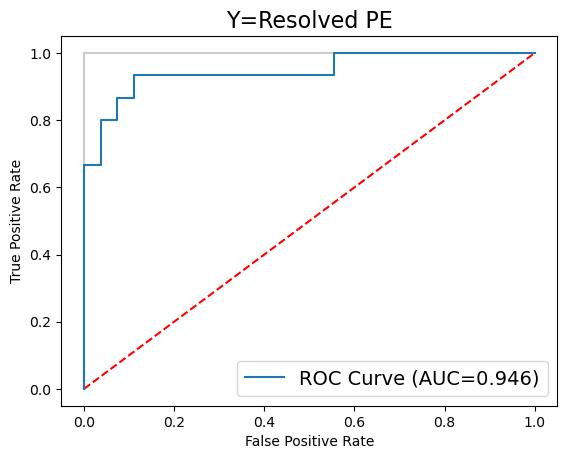

In [105]:
plot_roc(fpr, tpr, auc)

#### Sequential Feature Selection

# OLD

In [115]:
# n_splits = 10
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

# true_labels = list()
# predicted_probs = list()

# feats = ['density_bone']
# X_temp = X_scale[feats]

# for train_index, test_index in kf.split(X_temp):
# 	X_train, X_test = X_temp.iloc[train_index], X_temp.iloc[test_index]
# 	y_train, y_test = y.iloc[train_index], y.iloc[test_index]
	
# 	model = sm.Logit(y_train, X_train).fit(disp=False)
# 	y_probs = model.predict(X_test)
	
# 	true_labels.extend(np.squeeze(np.array(y_test)))
# 	predicted_probs.extend(y_probs)
	
# true_labels = np.array(true_labels)
# predicted_probs = np.array(predicted_probs)

# # Compute the ROC curve
# fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)

# # Compute the AUC
# auc = roc_auc_score(true_labels, predicted_probs)

# # Plot the ROC curve
# plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:0.3f})')
# plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic', fontsize=16)
# plt.legend(loc='lower right', fontsize=14)
# plt.show()

In [116]:
# (
# 	params, pvalues, nobs, 
# 	fpr, tpr, thresholds, auc
# ) = logit_regression(X_scale, y, 'density_bone')

# plot_roc(fpr, tpr, auc)

In [117]:
# fig, ax = plt.subplots()
# ax.plot([0, 1], ls='--', c='r')
# ax.plot([0, 0], [1, 0], c='0.8')
# ax.plot([1, 0], [1, 1], c='0.8')
# ax.plot(fpr, tpr)

# annot_x = 0.6
# annot_y = 0.2
# annotation = ax.annotate(
# 	f'AUC={auc:.3}',
# 	xy=(annot_x, annot_y), 
# 	xytext=(annot_x, annot_y), 
# 	textcoords='data',
# 	fontsize=16
# )
# plt.show()